In [1]:
from pandas.io.gbq import read_gbq
import pandas as pd
from bs4 import BeautifulSoup
import requests
import geopandas as gpd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
project = "spheric-crow-161317"
sample_query = "SELECT * FROM `smart_cities_data.mit_streetscore`"

mit_ss = read_gbq(query=sample_query, project_id=project, dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 62% done. Elapsed 15.55 s.
  Got page: 3; 93% done. Elapsed 25.89 s.
  Got page: 4; 100% done. Elapsed 28.92 s.
Got 322386 rows.

Total time taken 37.37 s.
Finished at 2017-03-27 00:14:01.


In [4]:
r=requests.get('https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm')
r.raise_for_status()
doc=BeautifulSoup(r.text,'lxml')

data={'borough': [], 'neighborhood': [], 'zip': []}
for row in doc.find('table').find_all('tr'):
    vals=[td.text.strip() for td in row.find_all('td')]
    if len(vals)==3:
        borough=vals.pop(0)
    if len(vals)==2:
        neighborhood, zips = vals
        for zipcode in zips.split(','):
            data['borough'].append(borough)
            data['neighborhood'].append(neighborhood)
            data['zip'].append(zipcode.strip())
            
neighborhoods_by_zip = pd.DataFrame(data)
neighborhoods_by_zip.head()

,borough,neighborhood,zip
0,Bronx,Central Bronx,10453
1,Bronx,Central Bronx,10457
2,Bronx,Central Bronx,10460
3,Bronx,Bronx Park and Fordham,10458
4,Bronx,Bronx Park and Fordham,10467


In [5]:
zipcode_shape = gpd.GeoDataFrame.from_file("Downloads/nyc_2010_zcta_boundries_nyu_2451_34509_.geojson")
zipcode_shape['geometry'] = zipcode_shape['geometry'].to_crs(epsg=2263)
zipcode_shape.zcta.dtype
zipcode_shape.head()

,bcode,cartodb_id,geometry,note,zcta
0,36061,18,(POLYGON ((989545.2338407174 215899.8262413288...,None,10020
1,36061,28,(POLYGON ((1001261.975070576 237040.9787089045...,None,10030
2,36061,43,(POLYGON ((990051.7117367965 216811.1383272739...,None,10103
3,36085,82,(POLYGON ((929536.3843854789 157481.9829655792...,None,10314
4,36081,111,(POLYGON ((1061577.267027674 215265.7262753579...,None,11005


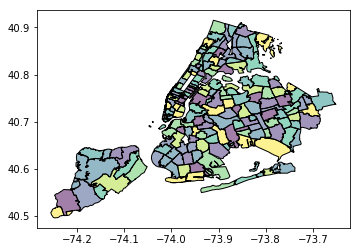

In [17]:
zipcode_shape.plot()

In [8]:
print(mit_ss.shape)
mit_ss.head()

(322386, 3)


,latitude,longitude,q_score
0,40.595036,-74.107162,25.046595
1,40.644485,-74.107162,33.453838
2,40.636635,-74.107162,24.252043
3,40.611935,-74.107162,19.828709
4,40.562534,-74.107162,25.193838


In [13]:
ss=gpd.GeoSeries(mit_ss.apply(lambda x: shapely.geometry.Point(x['longitude'],x['latitude']), axis=1))
ss.crs={'init': 'epsg:4326'}
mit_ss['geometry']=ss.to_crs(epsg=2263)

In [18]:
mit_ss.head()
mit_ss.crs={'init': 'epsg:4326'}

{'init': 'epsg:4326'} {'init': 'epsg:4326'}


In [20]:
zipcode_ss = gpd.sjoin(zipcode_shape, mit_ss, how="inner", op='intersects')
zipcode_ss.head()


,bcode,cartodb_id,geometry,note,zcta,index_right,latitude,longitude,q_score
0,36061,18,(POLYGON ((989545.2338407174 215899.8262413288...,None,10020,119235,40.760853,-73.983269,28.208687
0,36061,18,(POLYGON ((989545.2338407174 215899.8262413288...,None,10020,46160,40.760525,-73.983078,28.554100
0,36061,18,(POLYGON ((989545.2338407174 215899.8262413288...,None,10020,181989,40.760525,-73.982704,17.985525
0,36061,18,(POLYGON ((989545.2338407174 215899.8262413288...,None,10020,192441,40.760201,-73.982521,26.701992
0,36061,18,(POLYGON ((989545.2338407174 215899.8262413288...,None,10020,15811,40.760201,-73.982140,26.195036


In [21]:
zipcode_ss.shape

(318684, 9)

In [53]:
project = "spheric-crow-161317"
sample_query = "SELECT RegionName, City, State, Metro, CountyName, SizeRank, _2014_04 FROM `smart_cities_data.median_rents_zipcode_studio` WHERE City = 'New York'"

zillow_studio = read_gbq(query=sample_query, project_id=project, dialect='standard')
zillow_studio_clean = zillow_studio[~zillow_studio['_2014_04'].isnull()]


Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 49 rows.

Total time taken 0.53 s.
Finished at 2017-03-25 16:58:34.
  RegionName      City State     Metro CountyName  SizeRank  _2014_04
0      10458  New York    NY  New York      Bronx        25     950.0
2      11226  New York    NY  New York      Kings         8    1300.0
3      11211  New York    NY  New York      Kings        31    2500.0
4      11216  New York    NY  New York      Kings        42    1400.0
5      11209  New York    NY  New York      Kings        21    1200.0


C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [56]:
zillow_studio_clean['RegionName'] = zillow_studio_clean['RegionName'].astype(int64)
zipcode_shape['zcta'] = zipcode_shape['zcta'].astype(int64)
studio_shape = pd.merge(zillow_studio_clean, zipcode_shape, left_on='RegionName', right_on='zcta', how='inner')
studio_shape.head()
print(studio_shape.shape)

(47, 12)


C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [39]:
project = "spheric-crow-161317"
sample_query = "SELECT RegionName, City, State, Metro, CountyName, SizeRank, _2014_04 FROM `smart_cities_data.median_rents_zipcode_1br` WHERE City = 'New York'"

zillow_1br = read_gbq(query=sample_query, project_id=project, dialect='standard')
zillow_1br_clean = zillow_1br[~zillow_1br['_2014_04'].isnull()]
print(zillow_1br_clean.shape)
zillow_1br_clean.head()

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 104 rows.

Total time taken 0.75 s.
Finished at 2017-03-25 16:43:54.
(103, 7)


,RegionName,City,State,Metro,CountyName,SizeRank,_2014_04
0,10453,New York,NY,New York,Bronx,55,1166.5
1,10463,New York,NY,New York,Bronx,29,1350.0
2,10458,New York,NY,New York,Bronx,50,1100.0
3,10452,New York,NY,New York,Bronx,60,1150.0
4,10457,New York,NY,New York,Bronx,79,1195.0


In [40]:
project = "spheric-crow-161317"
sample_query = "SELECT RegionName, City, State, Metro, CountyName, SizeRank, _2014_04 FROM `smart_cities_data.median_rents_zipcode_2br` WHERE City = 'New York'"

zillow_2br = read_gbq(query=sample_query, project_id=project, dialect='standard')
zillow_2br_clean = zillow_2br[~zillow_2br['_2014_04'].isnull()]
print(zillow_2br_clean.shape)
zillow_2br_clean.head()

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 97 rows.

Total time taken 0.79 s.
Finished at 2017-03-25 16:44:30.
(85, 7)


,RegionName,City,State,Metro,CountyName,SizeRank,_2014_04
0,10462,New York,NY,New York,Bronx,20,1500.0
1,10461,New York,NY,New York,Bronx,302,1600.0
2,10467,New York,NY,New York,Bronx,7,1450.0
3,10468,New York,NY,New York,Bronx,82,1425.0
4,10463,New York,NY,New York,Bronx,26,1800.0


C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Nikita\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

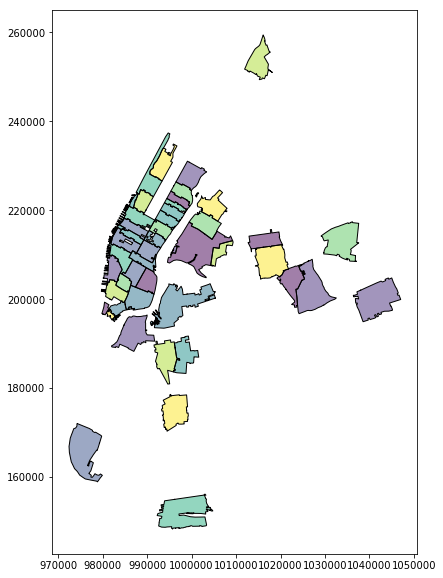

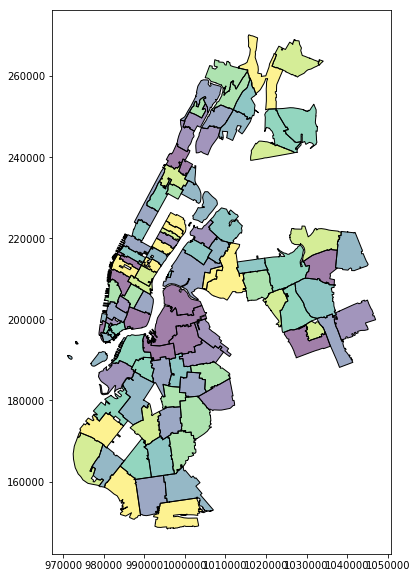

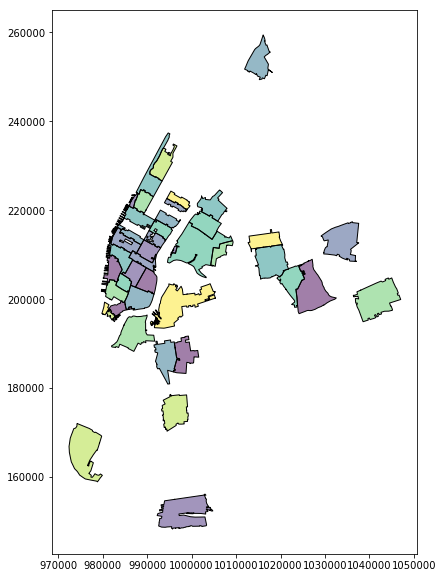

In [70]:
zillow_studio_clean['RegionName'] = zillow_studio_clean['RegionName'].astype(int64)
zipcode_shape['zcta'] = zipcode_shape['zcta'].astype(int64)
studio_shape = zipcode_shape.merge(zillow_studio_clean,left_on='zcta', right_on='RegionName', how='inner')
#studio_shape.to_file("studio_shape.geojson", driver="GeoJSON")
studio_shape.plot(figsize=(10,10))

zillow_1br_clean['RegionName'] = zillow_1br_clean['RegionName'].astype(int64)
zipcode_shape['zcta'] = zipcode_shape['zcta'].astype(int64)
onebr_shape = zipcode_shape.merge(zillow_1br_clean,left_on='zcta', right_on='RegionName', how='inner')
#onebr_shape.to_file("onebr_shape", driver="GeoJSON")
onebr_shape.plot(figsize=(10,10))

zillow_2br_clean['RegionName'] = zillow_studio_clean['RegionName'].astype(int64)
zipcode_shape['zcta'] = zipcode_shape['zcta'].astype(int64)
twobr_shape = zipcode_shape.merge(zillow_2br_clean,left_on='zcta', right_on='RegionName', how='inner')
#twobr_shape.to_file("twobr_shape", driver="GeoJSON")
twobr_shape.plot(figsize=(10,10))


In [64]:
pd.merge(studio_shape, his_data)

'C:\\Users\\Nikita'

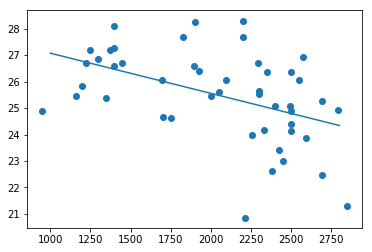

In [90]:
q_score = pd.read_csv("Downloads/agg_q_score.csv")
q_studio = studio_shape.merge(q_score, right_on='zcta', left_on='RegionName', how='inner')

results = sm.OLS(q_studio['q_score'],sm.add_constant(q_studio['_2014_04'])).fit()
#print(results.summary())

matplotlib.pyplot.scatter(q_studio['_2014_04'],q_studio['q_score'])
X_plot = np.linspace(1000,2800)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0])

plt.show()

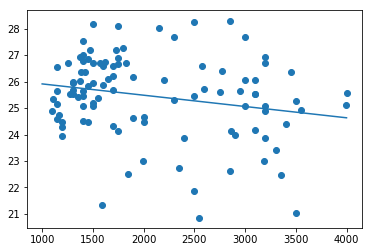

In [92]:
q_score = pd.read_csv("Downloads/agg_q_score.csv")
q_1br = onebr_shape.merge(q_score, right_on='zcta', left_on='RegionName', how='inner')

results = sm.OLS(q_1br['q_score'],sm.add_constant(q_1br['_2014_04'])).fit()
#print(results.summary())

matplotlib.pyplot.scatter(q_1br['_2014_04'],q_1br['q_score'])
X_plot = np.linspace(1000,4000)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0])

plt.show()

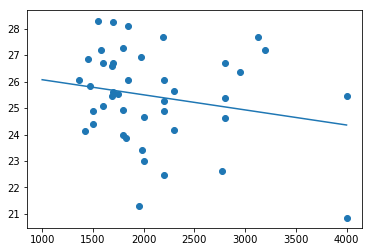

In [93]:
q_score = pd.read_csv("Downloads/agg_q_score.csv")
q_2br = twobr_shape.merge(q_score, right_on='zcta', left_on='RegionName', how='inner')

results = sm.OLS(q_2br['q_score'],sm.add_constant(q_2br['_2014_04'])).fit()
#print(results.summary())

matplotlib.pyplot.scatter(q_2br['_2014_04'],q_2br['q_score'])
X_plot = np.linspace(1000,4000)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0])

plt.show()